# Drawing Guesser 
## Pedro Luiz & Gabriel Zezze

### O dataset
O drawing guesser se baseia no [dataset de desenhos dispopnibilizados pelo Google](https://github.com/googlecreativelab/quickdraw-dataset) gerado através do jogo [QuickDraw](https://quickdraw.withgoogle.com/).

O dataset completo consiste de 150 mil desenhos que são imagens bitmap de 28x28 para cada categoria sendo que há 345 categorias disponibilizadas.

O intuito do drawing guesser é simular o proprio QuickDraw, ou seja, fazer classificações do desenho enquanto o jogador desenha, porém com um número limitado de catogrias (x) e uma rede neural própria treinada a partir do dataset disponibilizado.

### O problema

Este é um problema de classifição multiclasse dos desenhos dispoinibilizados no dataset. Para realizar essa classificação vamos utilizar uma rede convulacional que será explicada detalhadamente abaixo.


In [1]:
#IMPORTS
import pandas as pd
import numpy as np
import ujson as json
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, BatchNormalization
import tensorflow as tf
from sklearn.metrics import classification_report

In [2]:
#DECLARE CONSTANTS
IMG_HEIGHT = 28
IMG_WIDTH = 28
NUM_FILES = 35000
RF_NUM_FILES = 10000
N_EPOCHS = 300
RANDOM_SEED = 42

### Extração de dados

O dataset utilizado disponibiliza arquivos do tipo numpy bit array, que quando lidos com a função `numpy.load` retorna um numpy array. Contudo, esse array possui apenas uma dimensão. Dessa forma, é necessário fazer o reshape de cada imagem lida para se tornar uma matriz 28x28. 

In [3]:
#GETTING ALL FILE NAMES
data_files = os.listdir('./data/')
data_files = [f'./data/{file}' for file in data_files]
if data_files.count('./data/.DS_Store') > 0:
    data_files.remove('./data/.DS_Store')
N_CATEGORIES = len(data_files)

# data_files = [
#     '../data/book.npy',
#     '../data/bus.npy',
#     '../data/camel.npy',
#     '../data/apple.npy', 
#     '../data/airplane.npy',
#     '../data/cactus.npy',
#     '../data/bush.npy',
#     '../data/butterfly.npy',
#     '../data/calculator.npy',
#     '../data/bird.npy',
#     '../data/ambulance.npy',
#     '../data/cake.npy',
#     '../data/beach.npy',
#     '../data/axe.npy',
#     '../data/banana.npy',
#     '../data/calendar.npy',
#     '../data/alarm clock.npy',
#     '../data/basketball.npy',
#     '../data/bed.npy',
#     '../data/barn.npy'
# ]

print(data_files)
print(N_CATEGORIES)

['./data/book.npy', './data/bus.npy', './data/mushroom.npy', './data/camel.npy', './data/apple.npy', './data/airplane.npy', './data/cactus.npy', './data/butterfly.npy', './data/bird.npy', './data/hand.npy', './data/cake.npy', './data/axe.npy', './data/banana.npy', './data/calendar.npy', './data/alarm clock.npy', './data/donut.npy', './data/basketball.npy', './data/crayon.npy', './data/bed.npy', './data/barn.npy']
20


In [4]:
#READING FILES AND POPULATING TOTAL X AND Y
all_drawings = []
all_categories = []

for idx, file in enumerate(data_files):
    data = np.load(file)[:NUM_FILES]
    for d in data:
        reshaped_img = np.array(np.reshape(d, (-1, 28))).astype(np.float32)
        
        all_drawings.append(reshaped_img)
        all_categories.append(idx)

all_drawings = np.array(all_drawings)
all_categories = np.array(all_categories)

### Selecao de dados entre dados de treinamento e teste

Antes de qualquer treinamento ou teste em cima dos dados é necessário separá-los em dados de treinamento e teste sendo 20% dos dados seprados para teste e o restante para treinamento. 

Após essa separação os dados de trinamento serão divididos mais uma vez, sendo que 80% deste dados serao para treinamento do modelo e 20% para validação do treinamento.


In [5]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(all_drawings, all_categories, test_size=0.2, random_state=RANDOM_SEED)

## Estabelecendo uma base
Antes de iniciar a criação da rede convolucional, precisamos de uma base para saber se nosso modelo faz classificaçõeses melhores que modelos aleatórios. Para isso vamos utilizar o classificador Random Forrest para estabelecer um mínimo de performance para nosso modelo convolucional. Dessa forma, se a rede concolucional criada possuir desempenho similar ao classificador aleatório, não podemos dizer que obtivemos qualquer sucesso.

Como o classificador Random forrest recebe dados de treinamento de uma forma diferente (Vetores de no máximo duas dimensões) que uma rede convolucional, precisamos mudar o formato das features para treiná-lo.
Após treinar o classificador Random forest usamos o método `cross_val_score` para separarmos os dados de treinamento em 5 divisoes. Esse método combina 4 divisões para treinamento e a divisão restante para validação. Por fim, obtivemos os seguintes valores de acurácia de validação:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf_drawings = np.array([all_drawings[i:i + RF_NUM_FILES] for i in range(0, len(all_drawings), NUM_FILES)])
rf_drawings = np.concatenate([draw for draw in rf_drawings])

rf_categories = np.array([all_categories[i:i + RF_NUM_FILES] for i in range(0, len(all_categories), NUM_FILES)])
rf_categories = np.concatenate([cat for cat in rf_categories])

X_rf_train_full, X_rf_test, y_rf_train_full, y_rf_test = train_test_split(rf_drawings, rf_categories, test_size=0.2, random_state=RANDOM_SEED)

random_forest_X_train = np.array([x.flatten() for x in X_rf_train_full])
random_forrest_clf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)

cv_rf_score = cross_val_score(random_forrest_clf, random_forest_X_train, y_rf_train_full, cv=5, n_jobs=-1)
for idx, val in enumerate(cv_rf_score):
    print(f"{idx+1}:  {round(val*100, 2)}%")

### Montagem da rede convolucional

O modelo criado possui 3 conjuntos de camadas convolucionais seguidas de um max pooling. Os filtros da camada convolucional começam em 8 e vão dobrando, já para o kernel initializer foi utilizado o padrão que é o `glorot_uniform` de tamanho 3x3. Essas primeiras camadas tem o objetivo de destacar as features únicas(detalhes) de cada categoria. Em seguida é realizado o Flatten para transformar todas as camadas em uma array 1D e um Batch Normalization para padronizar os valores, ou seja, centralizar sua média em 0 e o desvio padrão em 1. Também foi adicionada uma camada de Dropout para evitar o overfitting. Na sequência, os inputs normalizados  são passados para uma camada Densa, a qual recebe dois parametros, número de neurônios e função de ativação que sera usada, assim a camada densa recebe as features, multiplica pelos respectivos pesos e soma esta multiplicação para finalmente passar pela funcao de ativação. Em seguida é aplicada mais uma batch normalization e um dropout. Por fim, é aplicada mais uma camada Dense com units = número de categorias, com a função de ativação soft max, para obter o resultado da classificação.

#### Entradas e saídas das camadas
```
(28, 28, 1) -> Primeira camada Conv2D -> (28, 28, 8)
(28, 28, 8) -> Primerira camada Maxpooling2D -> (14, 14, 8)
(14, 14, 8) -> Segunda camada Conv2D -> (14, 14, 16)
(14, 14, 16) -> Segunda camada Maxpooling2D -> (7, 7, 16)
(7, 7, 16) -> Terceira camada Conv2D -> (7, 7, 32)
(7, 7, 32) -> Terceira camada Maxpooling2D -> (4, 4, 32)
(4, 4, 32) -> Flatten -> (512)
(512) -> Dense -> (30)
(30) -> Dense -> (N)
```

In [6]:
slice_index = int(len(X_train_full)*0.8)

X_train = X_train_full[:slice_index][..., np.newaxis]
X_valid = X_train_full[slice_index:][..., np.newaxis]

y_train = y_train_full[:slice_index][..., np.newaxis]
y_valid = y_train_full[slice_index:][..., np.newaxis]

X_test = X_test[..., np.newaxis]

In [7]:
model = keras.models.Sequential([
    Conv2D(filters=8, kernel_size=3,padding="same", activation="relu", input_shape=(IMG_HEIGHT,IMG_WIDTH,1)),
    MaxPool2D(pool_size=2),

    Conv2D(filters=16, kernel_size=3, padding="same", activation="relu"),
    MaxPool2D(pool_size=2),

    Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    MaxPool2D(pool_size=2),
    
    Flatten(),
    
    BatchNormalization(),
    Dropout(0.5, seed=RANDOM_SEED),
    Dense(units=30,activation="relu"),
    
    BatchNormalization(),
    Dropout(0.5, seed=RANDOM_SEED),
    Dense(units=N_CATEGORIES, activation="softmax"),
])

In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics = ['accuracy'])

In [9]:
history = model.fit(X_train,y_train,epochs = N_EPOCHS, validation_data=(X_valid, y_valid), batch_size=264)

Epoch 1/300
1697/1697 [==============================] - 12s 4ms/step - loss: 2.5430 - accuracy: 0.2696 - val_loss: 1.5124 - val_accuracy: 0.6212
Epoch 2/300
1697/1697 [==============================] - 6s 4ms/step - loss: 1.7055 - accuracy: 0.4942 - val_loss: 1.0901 - val_accuracy: 0.7275
Epoch 3/300
1697/1697 [==============================] - 6s 4ms/step - loss: 1.4047 - accuracy: 0.5863 - val_loss: 0.8934 - val_accuracy: 0.7703
Epoch 4/300
1697/1697 [==============================] - 6s 4ms/step - loss: 1.2448 - accuracy: 0.6352 - val_loss: 0.7832 - val_accuracy: 0.7934
Epoch 5/300
1697/1697 [==============================] - 6s 4ms/step - loss: 1.1461 - accuracy: 0.6670 - val_loss: 0.7133 - val_accuracy: 0.8089
Epoch 6/300
1697/1697 [==============================] - 6s 4ms/step - loss: 1.0819 - accuracy: 0.6883 - val_loss: 0.6719 - val_accuracy: 0.8203
Epoch 7/300
1697/1697 [==============================] - 6s 4ms/step - loss: 1.0355 - accuracy: 0.7021 - val_loss: 0.6358 - val_a

1697/1697 [==============================] - 6s 4ms/step - loss: 0.7127 - accuracy: 0.8060 - val_loss: 0.4167 - val_accuracy: 0.8866
Epoch 58/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.7113 - accuracy: 0.8066 - val_loss: 0.4144 - val_accuracy: 0.8875
Epoch 59/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.7103 - accuracy: 0.8066 - val_loss: 0.4145 - val_accuracy: 0.8877
Epoch 60/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.7099 - accuracy: 0.8069 - val_loss: 0.4131 - val_accuracy: 0.8876
Epoch 61/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.7078 - accuracy: 0.8068 - val_loss: 0.4144 - val_accuracy: 0.8876
Epoch 62/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.7053 - accuracy: 0.8076 - val_loss: 0.4108 - val_accuracy: 0.8879
Epoch 63/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.7056 - accuracy: 0.8075 - val_loss: 0.4105 - val_accuracy

1697/1697 [==============================] - 6s 4ms/step - loss: 0.6723 - accuracy: 0.8167 - val_loss: 0.3908 - val_accuracy: 0.8944
Epoch 114/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6704 - accuracy: 0.8176 - val_loss: 0.3913 - val_accuracy: 0.8940
Epoch 115/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6718 - accuracy: 0.8169 - val_loss: 0.3921 - val_accuracy: 0.8937
Epoch 116/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6685 - accuracy: 0.8181 - val_loss: 0.3920 - val_accuracy: 0.8938
Epoch 117/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6677 - accuracy: 0.8178 - val_loss: 0.3914 - val_accuracy: 0.8945
Epoch 118/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6686 - accuracy: 0.8177 - val_loss: 0.3906 - val_accuracy: 0.8941
Epoch 119/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6678 - accuracy: 0.8182 - val_loss: 0.3921 - val_ac

Epoch 169/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6525 - accuracy: 0.8219 - val_loss: 0.3828 - val_accuracy: 0.8958
Epoch 170/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6523 - accuracy: 0.8227 - val_loss: 0.3807 - val_accuracy: 0.8971
Epoch 171/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6543 - accuracy: 0.8217 - val_loss: 0.3813 - val_accuracy: 0.8971
Epoch 172/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6522 - accuracy: 0.8227 - val_loss: 0.3815 - val_accuracy: 0.8973
Epoch 173/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6521 - accuracy: 0.8221 - val_loss: 0.3817 - val_accuracy: 0.8968
Epoch 174/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6523 - accuracy: 0.8222 - val_loss: 0.3808 - val_accuracy: 0.8973
Epoch 175/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6519 - accuracy: 0.8225 - val_loss: 0

Epoch 225/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6435 - accuracy: 0.8244 - val_loss: 0.3750 - val_accuracy: 0.8985
Epoch 226/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6449 - accuracy: 0.8248 - val_loss: 0.3746 - val_accuracy: 0.8987
Epoch 227/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6432 - accuracy: 0.8250 - val_loss: 0.3764 - val_accuracy: 0.8984
Epoch 228/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6421 - accuracy: 0.8254 - val_loss: 0.3757 - val_accuracy: 0.8986
Epoch 229/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6437 - accuracy: 0.8248 - val_loss: 0.3741 - val_accuracy: 0.8985
Epoch 230/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6439 - accuracy: 0.8244 - val_loss: 0.3747 - val_accuracy: 0.8984
Epoch 231/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6441 - accuracy: 0.8244 - val_loss: 0

Epoch 281/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6378 - accuracy: 0.8265 - val_loss: 0.3714 - val_accuracy: 0.8994
Epoch 282/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6399 - accuracy: 0.8254 - val_loss: 0.3743 - val_accuracy: 0.8978
Epoch 283/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6387 - accuracy: 0.8263 - val_loss: 0.3726 - val_accuracy: 0.8986
Epoch 284/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6386 - accuracy: 0.8264 - val_loss: 0.3753 - val_accuracy: 0.8974
Epoch 285/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6380 - accuracy: 0.8266 - val_loss: 0.3719 - val_accuracy: 0.8991
Epoch 286/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6382 - accuracy: 0.8270 - val_loss: 0.3716 - val_accuracy: 0.8993
Epoch 287/300
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6374 - accuracy: 0.8265 - val_loss: 0

In [10]:
model.save('./trained_models/')

INFO:tensorflow:Assets written to: ./trained_models/assets


INFO:tensorflow:Assets written to: ./trained_models/assets


### Análise do treinamento
Pode-se perceber pelos gráficos 1 e 2 que o modelo apresenta uma melhora na acurácia e no erro a cada iteração. Além disso, a validação acompanha essa melhora do treinamento, ou seja, o modelo apresenta bons resultados para o que ele está sendo treinado e também para dados genéricos(dados que nao estavam presente no treinamento), eliminando a possibilidade de overfitting. Por fim, a acurácia de validação do treinamento e o erro dessa validação são melhores que o próprio treinamento, visto que há duas camadas de dropout durante o treinamento, que eliminam aleatóriamente alguns dados de entrada, mas mantendo a soma total das entradas. Dessa forma, o modelo não se acomoda com os dados de treinamento e é obrigado a ser capaz de generalizar (evitando overfitting).

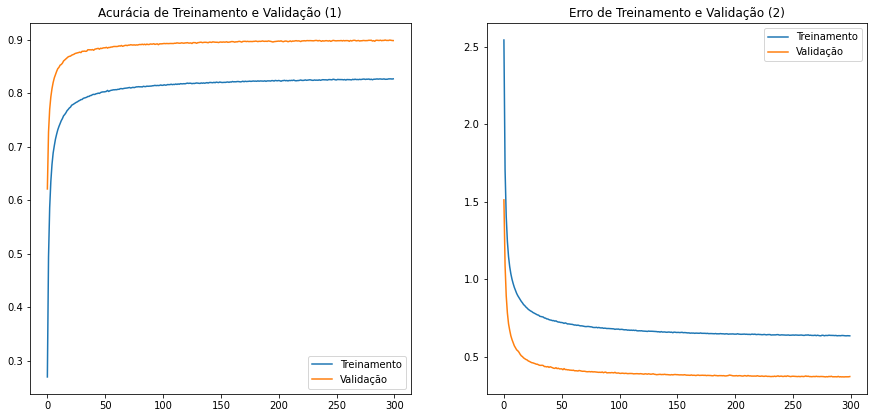

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(N_EPOCHS)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Treinamento')
plt.plot(epochs_range, val_acc, label='Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treinamento e Validação (1)')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Treinamento')
plt.plot(epochs_range, val_loss, label='Validação')
plt.legend(loc='upper right')
plt.title('Erro de Treinamento e Validação (2)')
plt.show()

In [12]:
# score = model.evaluate(X_test, y_test)

In [13]:
model = tf.keras.models.load_model(f'../model/trained_models')

In [ ]:
predictions = model.predict_classes(X_test)

categories = [x.split('/')[-1].split('.')[0] for x in data_files]

### Conclusão

A partir da matriz de confusão gerada com as predições dos dados de teste, pode-se perceber que a média de acurácia é aproximadamente 90%, contudo há algumas classes que se distanciam desse valor. Por exemplo, a classe `bus` acurácia mais baixa que a média e pode-se perceber que há muitos falsos positivos, ou seja, o modelo acha que é um ônibus, mas na verdade não é, e a maioria desses falsos positivos são ambulâncias, o que é bem plausível. Esse mesmo fenômeno ocorre ao contrário. Além disso, isso ocorre com pássaros e aviões e também calendários e calculadoras.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions, normalize='pred')
cmd = ConfusionMatrixDisplay(cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(15,15))
cmd.plot(ax=ax, xticks_rotation='vertical', values_format = '.2f')

Por fim, obtivemos os dados de precision, recall e f1 score. A acurácia final do modelo foi de `88%`. Com esses dados, podemos ver que a classe `beach` possui um precision bem menor que o recall, o que pode ser comprovado na matriz de confusão. O eixo vertical dessa classe(tirando a predição certa) representa os falsos positivos, já o horizontal os falsos negativos. Como o precision é menor a soma desses valores do eixo vertical é maior do que as do eixo horizontal. Além disso, esses valores que representam os falsos positivos estão muito espalhados, o modelo acha que muitas categorias são `beach`, quando não são.

In [ ]:
print(classification_report(y_test, predictions, target_names = categories)) 